## Rewrite
So what we really want is to minise all 4 independantly. I cant think of a good loss funciton for that so Im going to run 4 minimisations and pick the best.

In [16]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import struct

In [17]:
#layer = np.array([0,1,2,3,4,5,6,7])
#wire = np.array([2,2,2,2,2,2,2,2])
#tdc = np.array([9,190,59,121,129,51,198,17])

DIVIDER = 2000

In [18]:
def conv_hit_to_coords(l : np.array, w : np.array):
    # if l is odd, add 0.5 to it
    x = l
    y = w+ 0.5*(l%2)
    return (x, y)

def get_basic_plot(ev, ax=0):
    if ax == 0:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)

    for i in range(8):
        for j in range(8):
            x, y = conv_hit_to_coords(i,j)
            ax.plot(x, y, 'k.')

    x, y = conv_hit_to_coords(ev.layer, ev.wire)
    ax.plot(x, y, 'rx')
    ax.set(xlabel='Layer', ylabel='Wire',)
    return ax

def plot_TDC_circles(ax, ev, v=1):
    
    for i in range(8):
        x, y = conv_hit_to_coords(ev.layer[i], ev.wire[i])
        ax.add_artist(plt.Circle((x,y), ev.tdc[i] / DIVIDER * v, color='b', fill=False))
    
    return ax


In [19]:
# ax + bY + c = 0
class line:
    def __init__(self, a , b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def plot(self, ax, xmin, xmax):
        x = np.linspace(xmin, xmax, 100)
        y = (-self.a * x - self.c) / self.b
        ax.plot(x, y)
        return ax

class circle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    
    def plot(self, ax):
        ax.add_artist(plt.Circle((self.x, self.y), self.r, color='b', fill=False))
        return ax


def get_tangents_to_two_circles(c1, c2):
    ls = []

    # four solutions
    for i in [-1, 1]:
        for j in [-1, 1]:
            r1 = c1.r * i
            r2 = c2.r * j

            dr = r2 - r1

            x = c2.x - c1.x
            y = c2.y - c1.y

            z = x**2 + y**2
            #print("z>",z)
            d = np.sqrt( np.abs(z - dr**2) )

            a = (x * dr + y*d)/z
            b = (y * dr - x*d)/z
            c = r1 - c1.x * a - c1.y * b

            l = line(a, b, c)  
            ls.append(l) 

    return ls

# slightly faster than get_tangents to two circles
# (when written in c)
def get_nth_tangents_to_two_circles(c1, c2, n):
    
    if n == 0:
        i = 1
        j = 1
    
    elif n == 1:
        i = 1
        j = -1
    
    elif n== 2:
        i = -1
        j = 1
    
    else:
        i = -1
        j = -1

    # four solutions

    r1 = c1.r * i
    r2 = c2.r * j

    dr = r2 - r1

    x = c2.x - c1.x
    y = c2.y - c1.y

    z = x**2 + y**2
    d = np.sqrt( np.abs(z - dr**2) )

    a = (x * dr + y*d)/z
    b = (y * dr - x*d)/z
    c = r1 - c1.x * a - c1.y * b

    l = line(a, b, c)  

    return l

# basic sum of distances as loss function
def sumf(x):
    return x

def sqrtf(x):
    return np.sqrt(x)

def invf(x):
    return 1/x

def inv_sqrtf(x):
    return 1/np.sqrt(x)

def logxf(x):
    return np.log(x)

def squaref(x):
    return x**2

def circle_line_dist(ev, l : line, v : float, c1_num : float, c2_num : float, loss_f) -> float:
    # return the total distance to the line from the 6 other circles
    total_distance = 0.
    for i in range(8):
        if (i != c1_num) or (i != c2_num):
            ci_coords = conv_hit_to_coords(ev.layer[i], ev.wire[i])
            ci = circle(ci_coords[0], ci_coords[1], ev.tdc[i] / DIVIDER * v)
            total_distance += loss_f(np.abs(l.a * ci.x + l.b * ci.y + l.c) / np.sqrt(l.a**2 + l.b**2))

    return total_distance

def largest_circles(ev):
    max1 = np.argmax(ev.tdc)
    temp = ev.tdc.copy()
    temp[max1] = 0
    max2 = np.argmax(temp)
    return max1, max2


In [20]:
class event:
    def __init__(self, ith, fname='../data/manytracks.raw'):
        self.ith = ith
        self.fname = fname
        self.layer = []
        self.wire = []
        self.tdc = []
        self.best_v = 0
        self.best_v_tangent_number = 5

        # load the ith event
        with open(fname, 'rb') as file:

            file.seek(ith*16)
            event_data = file.read(16)
            data = list(event_data)
            if not event_data:
                return

            # Process each hit (2 bytes per hit, 8 hits per event)
            for i in range(8):
                hit_data = event_data[i*2:(i+1)*2]
                if len(hit_data) < 2:
                    continue  # Skip incomplete data

                # Unpack the 16-bit datum (little-endian)
                datum = struct.unpack('<H', hit_data)[0]

                # Extract the layer number (lowest 3 bits)
                layer_number = datum & 0b111

                # Extract the wire number (next 3 bits)
                wire_number = (datum >> 3) & 0b111

                # Extract the TDC count (remaining 10 bits)
                tdc_count = (datum >> 6) & 0b1111111111

                self.layer.append(layer_number)
                self.wire.append(wire_number)
                self.tdc.append(tdc_count)
        
        self.layer = np.array(self.layer)
        self.wire = np.array(self.wire)
        self.tdc = (np.array(self.tdc) * 0.5) + 0.25 # bin centers
    
    def plot(self, ax=0):
        if ax == 0:
            ax=plot_TDC_circles(get_basic_plot(self), self, v=self.best_v)
        else:
            ax=plot_TDC_circles(get_basic_plot(self, ax), self, v=self.best_v)
        c1_num, c2_num = largest_circles(self)
        c1_coords = conv_hit_to_coords(self.layer[c1_num], self.wire[c1_num])
        c2_coords = conv_hit_to_coords(self.layer[c2_num], self.wire[c2_num])
        c1 = circle(c1_coords[0], c1_coords[1], self.tdc[c1_num] / DIVIDER * self.best_v)
        c2 = circle(c2_coords[0], c2_coords[1], self.tdc[c2_num] / DIVIDER * self.best_v)
        l = get_nth_tangents_to_two_circles(c1, c2, self.best_v_tangent_number)
        l.plot(ax, 0, 8)


e1 = event(0, "../data/onetrack.raw")

In [21]:
def f(v, i, c1_coords, c2_coords, tdc, i_c1, i_c2, ev, loss_f=sumf):
    """
    v: velocity
    i: line tangent line number
    """

    # setup circles
    c1 = circle(c1_coords[0], c1_coords[1], tdc[i_c1] / DIVIDER * v)
    c2 = circle(c2_coords[0], c2_coords[1], tdc[i_c2] / DIVIDER * v)

    # get tangent
    l = get_nth_tangents_to_two_circles(c1, c2, i)

    return circle_line_dist(ev, l, v, i_c1, i_c2, loss_f)

def dfdv(v, i, c1_coords, c2_coords, tdc, i_c1, i_c2, ev, loss_f, epsilon):
    return (f(v+epsilon, i, c1_coords, c2_coords, tdc, i_c1, i_c2, ev, loss_f) - f(v-epsilon, i, c1_coords, c2_coords, tdc, i_c1, i_c2, ev, loss_f)) / (2 * epsilon)


In [22]:
def gradient_decent(ev, i, loss_f, eta, max_iter, x0, epsilon):
    c1_num, c2_num = largest_circles(ev)
    c1_coords = conv_hit_to_coords(ev.layer[c1_num], ev.wire[c1_num])
    c2_coords = conv_hit_to_coords(ev.layer[c2_num], ev.wire[c2_num])
    grad = dfdv(x0, i, c1_coords, c2_coords, ev.tdc, c1_num, c2_num, ev, loss_f, epsilon)
    
    for i in range(max_iter):
        x0 -= eta * grad

        grad = dfdv(x0, i, c1_coords, c2_coords, ev.tdc, c1_num, c2_num, ev, loss_f, epsilon)
        if grad < 1e-6:
            return x0
    return x0


In [23]:
def run(ev : event, loss_f=sumf, x0=10, bounds=(0, 11), minfunc=0):
    # problem setup
    i_c1, i_c2 = largest_circles(ev)

    res_arr = []

    c1_coords = conv_hit_to_coords(ev.layer[i_c1], ev.wire[i_c1])
    c2_coords = conv_hit_to_coords(ev.layer[i_c2], ev.wire[i_c2])
    
    if minfunc == 0:
        for i in range(4):
            res_arr.append(minimize(f, x0=x0, args=(i, c1_coords, c2_coords, ev.tdc, i_c1, i_c2, ev, loss_f), bounds=[bounds], method="Nelder-Mead").x) # Might need to impliment my own gradient descent
    else:
        for i in range(4):
            res_arr.append([minfunc(ev, i, loss_f, eta=0.01, max_iter=10_000, x0=x0, epsilon=1e-6)])
    
    
    # find the best fit line
    best_distance = 1e99
    best_v = [0.]
    for i, r in enumerate(res_arr):
        d = f(r, i, c1_coords, c2_coords, ev.tdc, i_c1, i_c2, ev)
        if (d < best_distance):
            best_distance = d
            best_v = r
            ev.best_v_tangent_number = i
        #print(r.x, d)
    #print(best_v)
    ev.best_v = best_v[0]
    #return best_v, best_distance

run(e1)

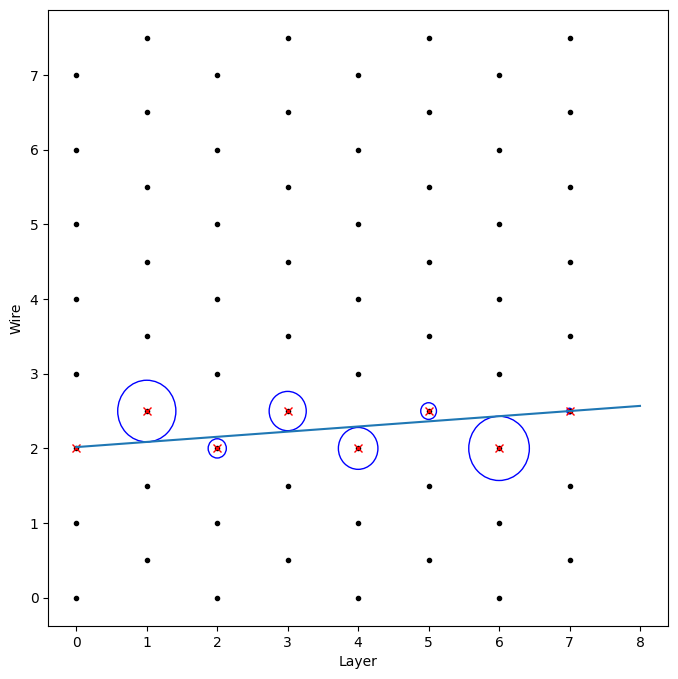

In [24]:
e1.plot()

In [25]:
def plot_f_for_event(ev : event, ax=0, loss_f=sumf):
    # plot the loss function for the event
    if ax == 0:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    v = np.linspace(-20, 20, 100000)

    i_c1, i_c2 = largest_circles(ev)
    print(i_c1, i_c2)

    c1_coords = conv_hit_to_coords(ev.layer[i_c1], ev.wire[i_c1])
    c2_coords = conv_hit_to_coords(ev.layer[i_c2], ev.wire[i_c2])

    for i in range(4):
        ax.plot(v, f(v, i, c1_coords, c2_coords, ev.tdc, i_c1, i_c2, ev, loss_f), label="tangent " + str(i))

    ax.plot(ev.best_v, f(ev.best_v, ev.best_v_tangent_number, c1_coords, c2_coords, ev.tdc, i_c1, i_c2, ev, loss_f), 'rx')

    ax.set(title="event {0}, loss_f: {3}\nv_min={1:.2f}, best_tangent={2}".format(ev.ith, ev.best_v, ev.best_v_tangent_number, loss_f.__name__), xlabel="v", ylabel="distance")
    ax.legend()

2 5
11.0


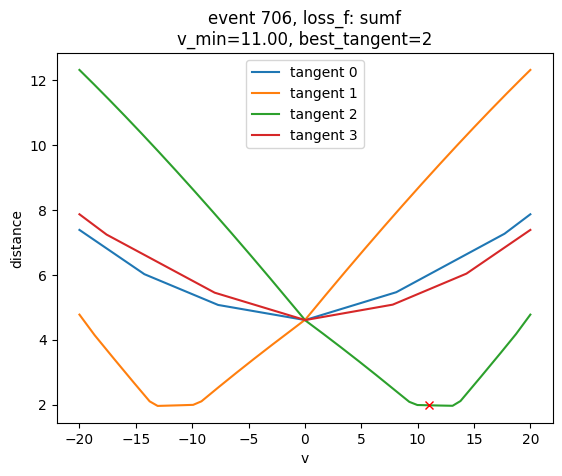

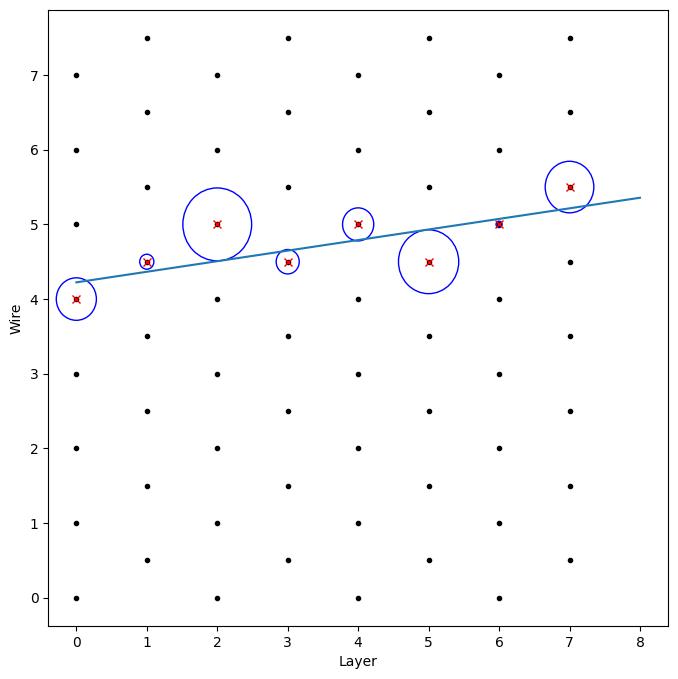

In [26]:
# look at event 702
e702 = event(706)
run(e702)
plot_f_for_event(e702)
e702.plot()
print(e702.best_v)

## Optimisation ideas
* Seems to be sort of degenerate solutions - is this generally the case?
    * IE do I need to check 4 each time?
* better loss function - square it so no -ves?
* GIVE IT BOUNDS
    * set a min size of v


2 5
2 5
2 5
2 5
2 5


/tmp/ipykernel_17272/1492038745.py:107: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


2 5


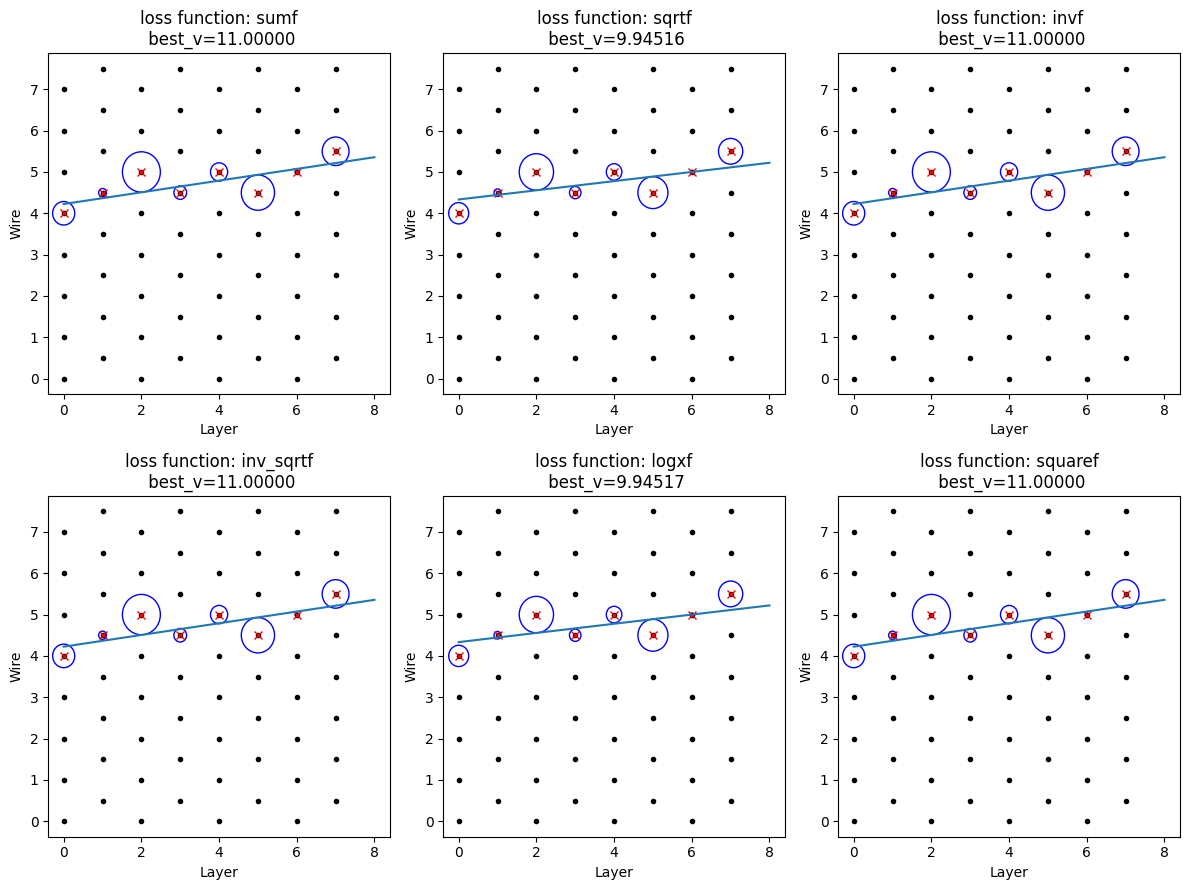

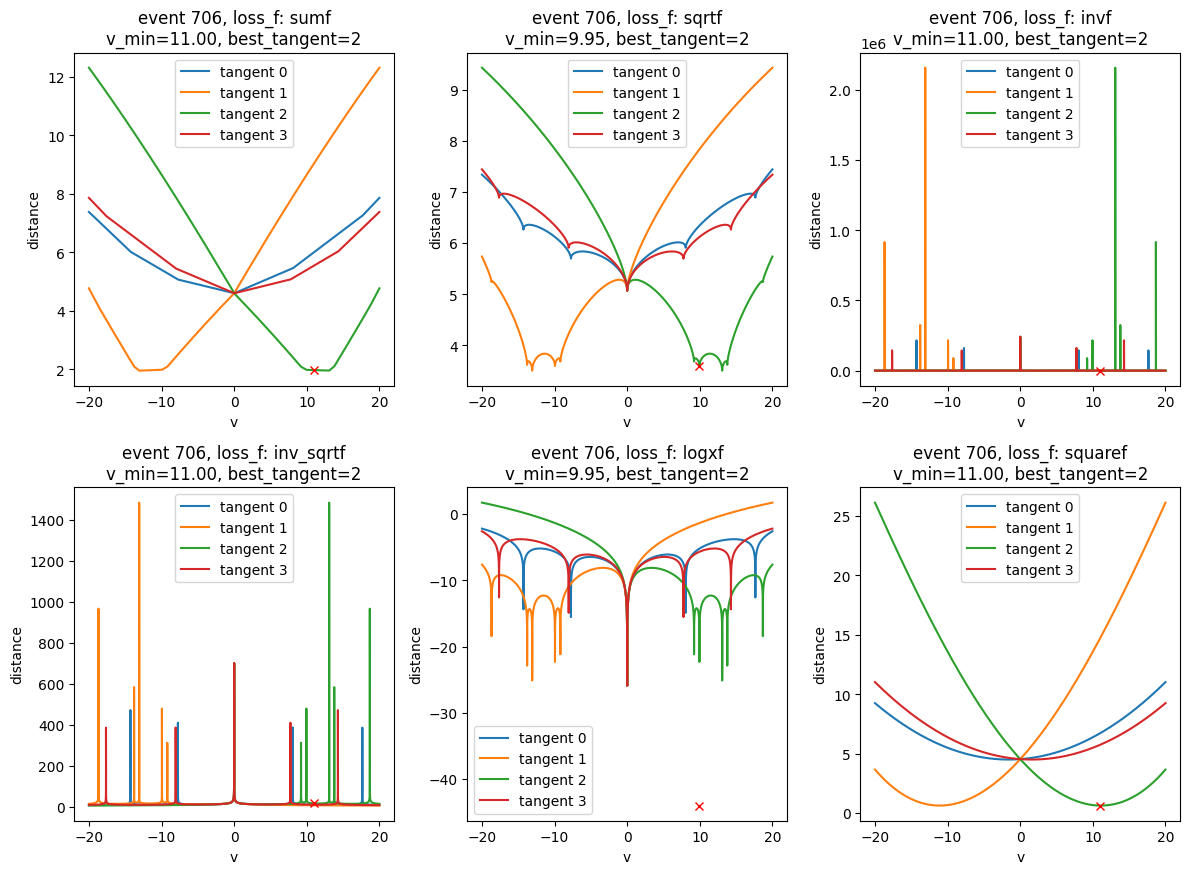

In [27]:
# e702 is a "difficult" event for example. Lets look at the results for all the loss functions
fig = plt.figure(figsize=(12,9))
ax = fig.subplots(2,3)

fig2 = plt.figure(figsize=(12,9))
ax2 = fig2.subplots(2,3)

lfs = [sumf, sqrtf, invf, inv_sqrtf, logxf, squaref]
for i, lf in enumerate(lfs):
    run(e702, loss_f=lf)
    
    e702.plot(ax=ax[int(i/3), i%3])
    ax[int(i/3), i%3].set(title="loss function: " + lf.__name__ + "\n best_v={0:.5f}".format(e702.best_v))

    plot_f_for_event(e702, ax2[int(i/3), i%3], loss_f=lf)

fig.tight_layout()
fig2.tight_layout()

fig.savefig("../plots/loss_functions_fits.png")
fig2.savefig("../plots/loss_functions_f.png")

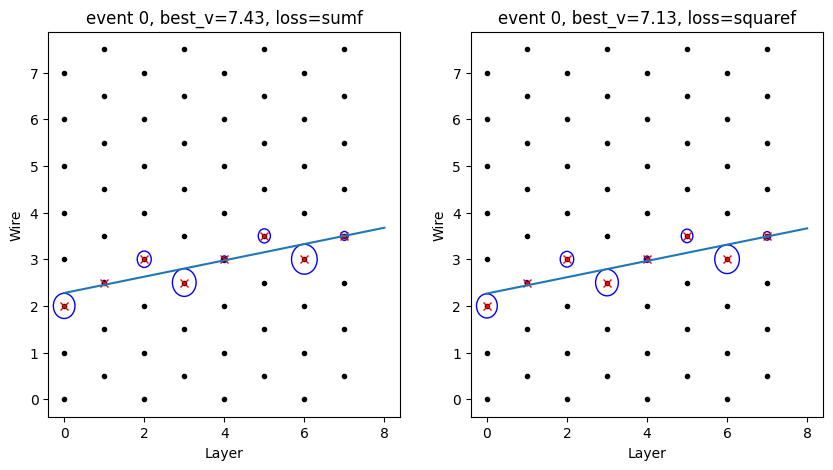

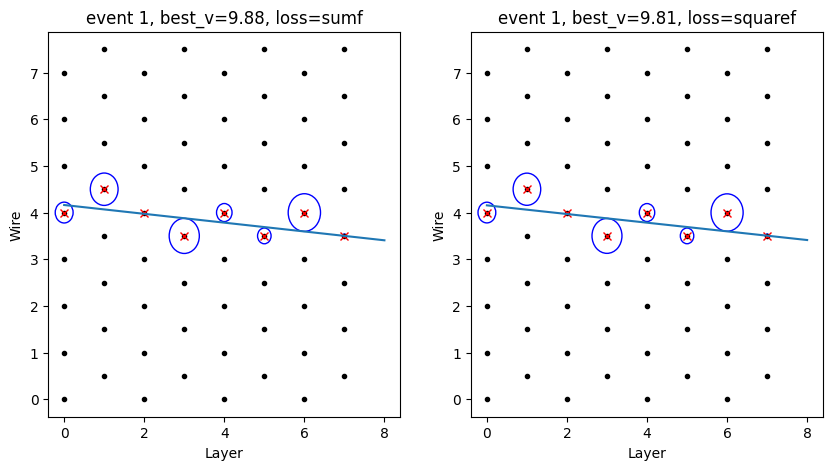

In [28]:
# now try some other "tricky" events
nevts = 2
for i in range(nevts):
    e = event(i, "../data/manytracks.raw")
    ax = plt.figure(figsize=(10,5)).subplots(1,2)
    for i, func in enumerate([sumf, squaref]):
        run(e, loss_f=func)
        ax[i].set(title="event {0}, best_v={1:.2f}, loss={2}".format(e.ith, e.best_v,func.__name__))
        e.plot(ax[i])
    fig.tight_layout()


6 3


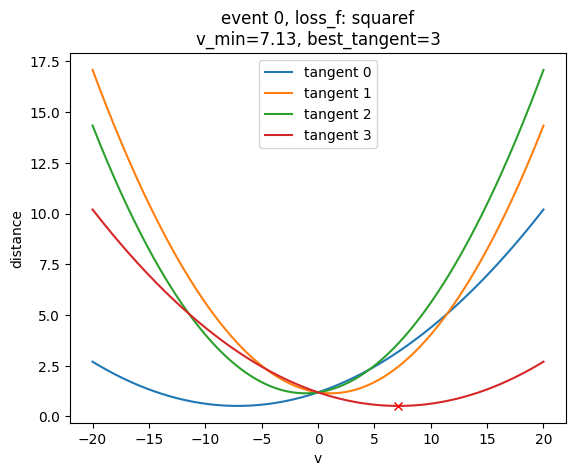

In [29]:
ev0 = event(0, "../data/manytracks.raw")
run(ev0, loss_f=squaref)
plot_f_for_event(ev0, loss_f=squaref)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

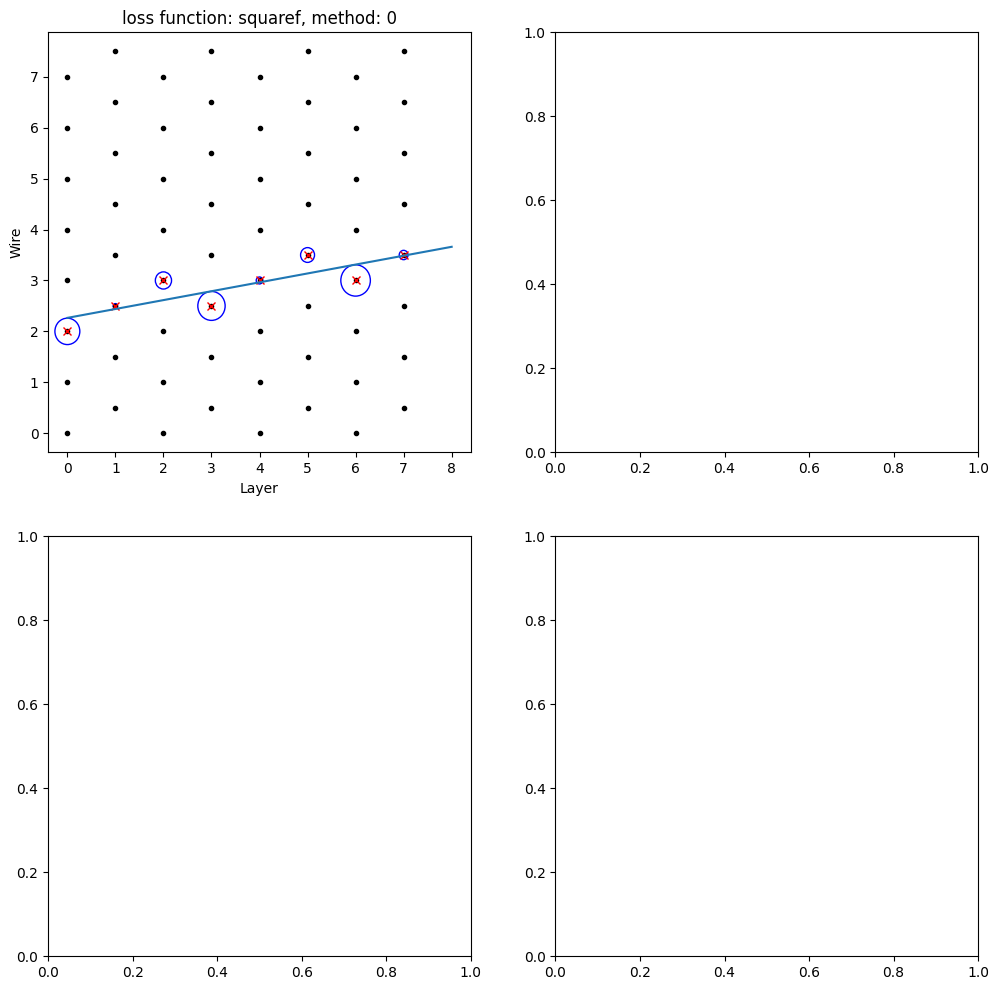

In [30]:
# trying gradient decent vs nelder mead for the loss functions

lf = [squaref, sumf]
methods = [0, gradient_decent]
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(2,2)

for i in range(2):
    for j in range(2):
        e = event(0, "../data/manytracks.raw")
        run(e, loss_f=lf[i], minfunc=methods[j])
        e.plot(ax=ax[i,j])
        ax[i,j].set(title="loss function: {0}, method: {1}".format(lf[i].__name__, methods[j]))

3.57623291015625 -1.3404277687811827e-06


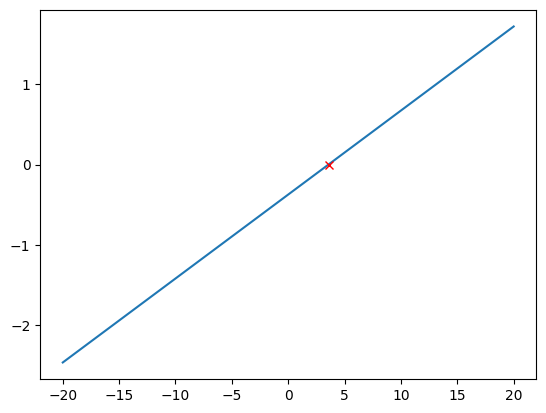

In [ ]:
# plot dfdv for the event
fig = plt.figure()
ax = fig.add_subplot(111)
v = np.linspace(-20, 20, 1000)
e702 = event(0)
i_c1, i_c2 = largest_circles(e702)
c1_coords = conv_hit_to_coords(e702.layer[i_c1], e702.wire[i_c1])
c2_coords = conv_hit_to_coords(e702.layer[i_c2], e702.wire[i_c2])
run(e702, loss_f=squaref)
ax.plot(v, dfdv(v, e702.best_v_tangent_number, c1_coords, c2_coords, e702.tdc, i_c1, i_c2, e702, squaref, epsilon=1e-6))
ax.plot(e702.best_v, dfdv(e702.best_v, e702.best_v_tangent_number, c1_coords, c2_coords, e702.tdc, i_c1, i_c2, e702, squaref, epsilon=1e-6), 'rx')
print(e702.best_v, dfdv(e702.best_v, e702.best_v_tangent_number, c1_coords, c2_coords, e702.tdc, i_c1, i_c2, e702, squaref, epsilon=1e-6))

In [ ]:
vlist = []

for i in range(20_000):
    e = event(i, "../data/manytracks.raw")
    run(e, loss_f=squaref)
    #e.plot()1000
    vlist.append(e.best_v)

[Text(0.5, 1.0, 'velocity distribution'),
 Text(0.5, 0, 'velocity [um/ns]'),
 Text(0, 0.5, 'count')]

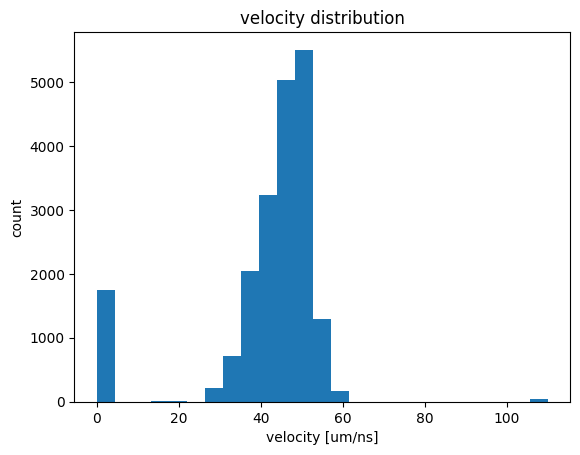

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

values, bins, _ = ax.hist(np.abs(vlist)/DIVIDER * 10_000, bins=25)
ax.set(title="velocity distribution", xlabel="velocity [um/ns]", ylabel="count")

In [ ]:
print(values[0])
print(values[0]/sum(values) * 100, "% did not converge :-(")

1745.0
8.725 % did not converge :-(


## Analysis
* A small search range HEAVILY improves the optimisation time
* squaref as a loss function seems to work more generally

In [ ]:
# Uncertainty on the optimisation
# We can get the hessian from the optimisation

# or not - might need to use a different method
#for r in res_arr:
#    print(r.x)
    #print(r.hess)